In [3]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression,classification, Pipeline, evaluation 
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

In [4]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [5]:
df = pd.read_csv('diabetic_data.csv')

In [6]:
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
for i in range(24,47): #No-0,Down-1,Up-2,Steady-3
    df[df.columns[i]] = df[df.columns[i]].map({'No': -2, 'Down': -1, "Up":1, 'Steady':0})

In [8]:
df['readmitted'] = df['readmitted'].map({'NO': 0, '<30': 1, ">30":2})
df['readmittedbinary'] = df['readmitted'].map({0: 0, 1: 1, 2:1})

In [9]:
df['change'] = df['change'].map({'No': -1, 'Ch': 1})#No-0,Ch-1

In [10]:
df['max_glu_serum'] = df['max_glu_serum'].map({'None': 0, '>200': 2,'>300':3,'Norm':1})

In [11]:
df['A1Cresult'] = df['A1Cresult'].map({'None': 0, '>7': 7,'>8':8,'Norm':5})

In [12]:
df['diabetesMed'] = df['diabetesMed'].map({'No': -1, 'Yes': 1})

In [13]:
df['age'] = df['age'].map({'[0-10)':5,'[10-20)':15, '[20-30)':25,'[30-40)':35,'[40-50)':45,'[50-60)':55,'[60-70)':65,'[70-80)':75,'[80-90)':85,'[90-100)':95})

In [14]:
df.drop(['encounter_id','patient_nbr','weight','admission_type_id','discharge_disposition_id','admission_source_id','medical_specialty','payer_code'],axis=1,inplace=True)


In [15]:
df=df.loc[df['gender'].isin(['Male','Female'])]#df.loc[df['B'].isin(['one','three'])]

In [16]:
df.replace('?', np.nan, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [17]:
df= df.dropna()##Clean pandas df without dummy variables 

In [18]:
df['max_glu_serum'].value_counts()

0    92844
1     2532
2     1449
3     1227
Name: max_glu_serum, dtype: int64

In [19]:
df.to_csv("clean.csv")

In [20]:
spark_df = spark.read.csv('clean.csv', header=True, inferSchema=True)

In [21]:
spark_df=spark_df.withColumnRenamed("glimepiride-poglitazone","glimepiridepoglitazone").withColumnRenamed("glyburide-metformin","glyburidemetformin").withColumnRenamed("glipizide-metformin","glipizidemetformin").withColumnRenamed("glimepiride-pioglitazone","glimepiridepioglitazone").withColumnRenamed("metformin-rosiglitazone","metforminrosiglitazone").withColumnRenamed("metformin-pioglitazone","metforminpioglitazone")

In [22]:
def amit(row):    
    ma=0
    mb=0
    mc=0
    md=0
    me=0
    sa=0
    sb=0
    dc=dr=dd=ddt=di=dm=dg=dn=dc2=dr2=dd2=ddt2=di2=dm2=dg2=dn2=dc3=dr3=dd3=ddt3=di3=dm3=dg3=dn3=0
    
    if "V" in row.diag_1 or "E" in row.diag_1:
        dc=dr=dd=ddt=di=dm=dg=dn=0
    elif 390 <= float(row.diag_1) <= 459 or float(row.diag_1) == 785:
        dc =1 ##Circulatory
    elif 460 <= float(row.diag_1) <= 519 or float(row.diag_1) == 786:
        dr =1 #Respiratory
    elif 520 <= float(row.diag_1) <= 579 or float(row.diag_1) == 787:
        dd =1 #Digestive
    elif 250 <= float(row.diag_1) <= 250.999:
        ddt =1 #Diabetes
    elif 800 <= float(row.diag_1) <= 999:
        di =1 #Injury
    elif 710 <= float(row.diag_1) <= 739:
        dm =1 #musculoskeletal
    elif 580 <= float(row.diag_1) <= 629 or float(row.diag_1) == 788:
        dg =1 #Genitourinary
    elif 140 <= float(row.diag_1) <= 239:
        dn =1 #Neoplasms
    else:
        dc=dr=dd=ddt=di=dm=dg=dn=0
        #do=1#others
        
    if "V" in row.diag_2 or "E" in row.diag_2:
        #do2=1
        dc2=dr2=dd2=ddt2=di2=dm2=dg2=dn2=0
    elif 390 <= float(row.diag_2) <= 459 or float(row.diag_2) == 785:
        dc2 =1 ##Circulatory
    elif 460 <= float(row.diag_2) <= 519 or float(row.diag_2) == 786:
        dr2 =1 #Respiratory
    elif 520 <= float(row.diag_2) <= 579 or float(row.diag_2) == 787:
        dd2 =1 #Digestive
    elif 250 <= float(row.diag_2) <= 250.999:
        ddt2 =1 #Diabetes
    elif 800 <= float(row.diag_2) <= 999:
        di2 =1 #Injury
    elif 710 <= float(row.diag_2) <= 739:
        dm2 =2 #musculoskeletal
    elif 580 <= float(row.diag_2) <= 629 or float(row.diag_2) == 788:
        dg2 =1 #Genitourinary
    #elif 140 <= float(row.diag_2) <= 239:
    #   dn2 =1 #Neoplasms
    else:
        #do2=1#others
        dc2=dr2=dd2=ddt2=di2=dm2=dg2=dn2=0
        
    if "V" in row.diag_3 or "E" in row.diag_3:
        #do3=1
        dc3=dr3=dd3=ddt3=di3=dm3=dg3=dn3=0
    elif 390 <= float(row.diag_3) <= 459 or float(row.diag_3) == 785:
        dc3 =1 ##Circulatory
    elif 460 <= float(row.diag_3) <= 519 or float(row.diag_3) == 786:
        dr3 =1 #Respiratory
    elif 520 <= float(row.diag_3) <= 579 or float(row.diag_3) == 787:
        dd3 =1 #Digestive
    elif 250 <= float(row.diag_3) <= 250.999:
        ddt3 =1 #Diabetes
    elif 800 <= float(row.diag_3) <= 999:
        di3 =1 #Injury
    elif 710 <= float(row.diag_3) <= 739:
        dm3 =1 #musculoskeletal
    elif 580 <= float(row.diag_3) <= 629 or float(row.diag_3) == 788:
        dg3 =1 #Genitourinary
    elif 140 <= float(row.diag_3) <= 239:
        dn3 =1 #Neoplasms
    else:
        dc3=dr3=dd3=ddt3=di3=dm3=dg3=dn3=0
        #do3=1#others  

    
    if row.race == "Caucasian":
        ma = 1
        #prfloat("A")
    elif row.race == "Asian":
        mb = 1
    elif row.race == "AfricanAmerican":
        mc = 1
    elif row.race =="Hispanic":
        me = 1
    else:# row.motor == "D":
        ma=0
        mb=0
        mc=0
        me = 0


    if row.gender == "Male":
        sa = 1
    elif row.gender == "Female":
        sb = 1
    
    
    r = Row(Caucasian=int(ma) ,Asian=int(mb) ,African_American=int(mc),Hispanic=int(me),male=float(sa),female=float(sb),age=row.age,time_in_hospital= row.time_in_hospital,num_lab_procedures = row.num_lab_procedures,
       num_procedures=row.num_procedures, num_medications=row.num_medications,number_outpatient = row.number_outpatient, number_emergency=row.number_emergency, number_inpatient=row.number_inpatient,
            Circulatory = dc,
            Respiratory=dr,
            Digestive= dd,
            Diabetes = ddt,
            Injury= di,
            Muscuskeletal= dm,
            Neoplasms=dn,
            Genitourinary = dg,
            
            
            Circulatory2 = dc2,
            Respiratory2=dr2,
            Digestive2= dd2,
            Diabetes2 = ddt2,
            Injury2= di2,
            Muscuskeletal2= dm2,
            Neoplasms2=dn2,
            Genitourinary2 = dg2,
            
            
            Circulatory3 = dc3,
            Respiratory3=dr3,
            Digestive3= dd3,
            Diabetes3 = ddt3,
            Injury3= di3,
            Muscuskeletal3= dm3,
            Neoplasms3=dn3,
            Genitourinary3 = dg3,
            
       number_diagnoses=row.number_diagnoses, 
            max_glu_serum =row.max_glu_serum,
            A1Cresult=row.A1Cresult, 
            metformin=row.metformin,
           repaglinide=row.repaglinide,
            nateglinide=row.nateglinide, 
            chlorpropamide = row.chlorpropamide, 
            glimepiride=row.glimepiride,
           acetohexamide=row.acetohexamide, 
            glipizide =row.glipizide, 
            glyburide=row.glyburide, 
            tolbutamide=row.tolbutamide,
           pioglitazone=row.pioglitazone, 
            rosiglitazone=row.rosiglitazone, 
            acarbose=row.acarbose, 
            miglitol=row.miglitol, 
            troglitazone=row.troglitazone,
           tolazamide=row.tolazamide, 
            examide=row.examide,
            citoglipton=row.citoglipton, 
            insulin=row.insulin, change=row.change, diabetesMed = row.diabetesMed, readmitted=row.readmitted,readmittedbinary=row.readmittedbinary,
           glyburidemetformin=row.glyburidemetformin,
           glipizidemetformin=row.glipizidemetformin,
            metforminpioglitazone=row.metforminpioglitazone,
            metforminrosiglitazone=row.metforminrosiglitazone,
            glimepiridepioglitazone=row.glimepiridepioglitazone)
    return(r)

In [23]:
dummy_df = spark.createDataFrame(spark_df.rdd.map(amit))


In [24]:
dummy_df.show()

+---------+----------------+-----+---------+-----------+------------+------------+--------+---------+---------+---------+----------+----------+-------------+--------------+--------------+--------+------+-------+-------+-------------+--------------+--------------+---------+----------+----------+-----------+------------+------------+--------+-------------+---+------+--------------+-----------+-----------+-------+------+-----------+-----------------------+---------+------------------+---------+------------------+-------+----+-------------+---------+---------------------+----------------------+--------+-----------+------------------+---------------+--------------+----------------+----------------+----------------+-----------------+------------+----------+----------------+-----------+-------------+----------------+----------+-----------+------------+
|A1Cresult|African_American|Asian|Caucasian|Circulatory|Circulatory2|Circulatory3|Diabetes|Diabetes2|Diabetes3|Digestive|Digestive2|Digestive3

In [25]:
dummy_df.select('Male','Female').show()#,'Male','Female', 'Circulatory','Circulatory2','Circulatory3').show()

+----+------+
|Male|Female|
+----+------+
| 0.0|   1.0|
| 0.0|   1.0|
| 1.0|   0.0|
| 1.0|   0.0|
| 1.0|   0.0|
| 1.0|   0.0|
| 1.0|   0.0|
| 0.0|   1.0|
| 0.0|   1.0|
| 0.0|   1.0|
| 1.0|   0.0|
| 0.0|   1.0|
| 1.0|   0.0|
| 0.0|   1.0|
| 1.0|   0.0|
| 1.0|   0.0|
| 0.0|   1.0|
| 1.0|   0.0|
| 0.0|   1.0|
| 0.0|   1.0|
+----+------+
only showing top 20 rows



In [26]:
dummy_df.printSchema()

root
 |-- A1Cresult: long (nullable = true)
 |-- African_American: long (nullable = true)
 |-- Asian: long (nullable = true)
 |-- Caucasian: long (nullable = true)
 |-- Circulatory: long (nullable = true)
 |-- Circulatory2: long (nullable = true)
 |-- Circulatory3: long (nullable = true)
 |-- Diabetes: long (nullable = true)
 |-- Diabetes2: long (nullable = true)
 |-- Diabetes3: long (nullable = true)
 |-- Digestive: long (nullable = true)
 |-- Digestive2: long (nullable = true)
 |-- Digestive3: long (nullable = true)
 |-- Genitourinary: long (nullable = true)
 |-- Genitourinary2: long (nullable = true)
 |-- Genitourinary3: long (nullable = true)
 |-- Hispanic: long (nullable = true)
 |-- Injury: long (nullable = true)
 |-- Injury2: long (nullable = true)
 |-- Injury3: long (nullable = true)
 |-- Muscuskeletal: long (nullable = true)
 |-- Muscuskeletal2: long (nullable = true)
 |-- Muscuskeletal3: long (nullable = true)
 |-- Neoplasms: long (nullable = true)
 |-- Neoplasms2: long (null

In [27]:
training_df, validation_df, testing_df = dummy_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [28]:
featlist = ['A1Cresult',
 'African_American',
 'Asian',
 'Caucasian',
 'Circulatory',
 'Circulatory2',
 'Circulatory3',
 'Diabetes',
 'Diabetes2',
 'Diabetes3',
 'Digestive',
 'Digestive2',
 'Digestive3',
 'Genitourinary',
 'Genitourinary2',
 'Genitourinary3',
 'Hispanic',
 'Injury',
 'Injury2',
 'Injury3',
 'Muscuskeletal',
 'Muscuskeletal2',
 'Muscuskeletal3',
 'Neoplasms',
 'Neoplasms2',
 'Neoplasms3',
 'Respiratory',
 'Respiratory2',
 'Respiratory3',
 'acarbose',
 'acetohexamide',
 'age',
 'change',
 'chlorpropamide',
 'citoglipton',
 'diabetesMed',
 'examide',
 'female',
 'glimepiride',
 'glimepiridepioglitazone',
 'glipizide',
 'glipizidemetformin',
 'glyburide',
 'glyburidemetformin',
 'insulin',
 'male',
 'max_glu_serum',
 'metformin',
 'metforminpioglitazone',
 'metforminrosiglitazone',
 'miglitol',
 'nateglinide',
 'num_lab_procedures',
 'num_medications',
 'num_procedures',
 'number_diagnoses',
 'number_emergency',
 'number_inpatient',
 'number_outpatient',
 'pioglitazone',
 'repaglinide',
 'rosiglitazone',
 'time_in_hospital',
 'tolazamide',
 'tolbutamide',
 'troglitazone']

# Logistic model 1 with all features no param

In [29]:
model1 = Pipeline(stages=[feature.VectorAssembler(inputCols=['A1Cresult',
 'African_American',
 'Asian',
 'Caucasian',
 'Circulatory',
 'Circulatory2',
 'Circulatory3',
 'Diabetes',
 'Diabetes2',
 'Diabetes3',
 'Digestive',
 'Digestive2',
 'Digestive3',
 'Genitourinary',
 'Genitourinary2',
 'Genitourinary3',
 'Hispanic',
 'Injury',
 'Injury2',
 'Injury3',
 'Muscuskeletal',
 'Muscuskeletal2',
 'Muscuskeletal3',
 'Neoplasms',
 'Neoplasms2',
 'Neoplasms3',
 'Respiratory',
 'Respiratory2',
 'Respiratory3',
 'acarbose',
 'acetohexamide',
 'age',
 'change',
 'chlorpropamide',
 'citoglipton',
 'diabetesMed',
 'examide',
 'female',
 'glimepiride',
 'glimepiridepioglitazone',
 'glipizide',
 'glipizidemetformin',
 'glyburide',
 'glyburidemetformin',
 'insulin',
 'male',
 'max_glu_serum',
 'metformin',
 'metforminpioglitazone',
 'metforminrosiglitazone',
 'miglitol',
 'nateglinide',
 'num_lab_procedures',
 'num_medications',
 'num_procedures',
 'number_diagnoses',
 'number_emergency',
 'number_inpatient',
 'number_outpatient',
 'pioglitazone',
 'repaglinide',
 'rosiglitazone',
 'time_in_hospital',
 'tolazamide',
 'tolbutamide',
 'troglitazone'],
                                        outputCol='features'),feature.StandardScaler(inputCol='features',outputCol = 'sdfeatures'),
                 classification.LogisticRegression(labelCol='readmittedbinary', featuresCol='sdfeatures')])


In [30]:
pipe_model = model1.fit(training_df)

In [31]:
pipe_modeldf = pipe_model.transform(validation_df).select("readmittedbinary","prediction")
pipe_modeldf.show()

+----------------+----------+
|readmittedbinary|prediction|
+----------------+----------+
|               0|       0.0|
|               1|       0.0|
|               1|       0.0|
|               0|       0.0|
|               0|       0.0|
|               0|       0.0|
|               0|       0.0|
|               1|       0.0|
|               0|       0.0|
|               0|       0.0|
|               0|       0.0|
|               0|       0.0|
|               0|       0.0|
|               0|       0.0|
|               0|       0.0|
|               1|       0.0|
|               0|       0.0|
|               1|       1.0|
|               0|       0.0|
|               1|       0.0|
+----------------+----------+
only showing top 20 rows



In [32]:
tp = pipe_modeldf[(pipe_modeldf.readmittedbinary == 1) & (pipe_modeldf.prediction == 1)].count()
tn = pipe_modeldf[(pipe_modeldf.readmittedbinary == 0) & (pipe_modeldf.prediction == 0)].count()
fp = pipe_modeldf[(pipe_modeldf.readmittedbinary == 0) & (pipe_modeldf.prediction == 1)].count()
fn = pipe_modeldf[(pipe_modeldf.readmittedbinary == 1) & (pipe_modeldf.prediction == 0)].count()
print ("True Positives:", tp)
print ("True Negatives:", tn)
print ("False Positives:", fp)
print ("False Negatives:", fn)
#print ("Total", df.count())

r = (tp)/(tp + fn)
print ("recall", r)

p = float(tp) / (tp + fp)
print ("precision", p)

True Positives: 5719
True Negatives: 12397
False Positives: 3323
False Negatives: 7892
recall 0.42017485857027403
precision 0.6324928113249281


In [33]:
evaluator = evaluation.BinaryClassificationEvaluator(labelCol='readmittedbinary')
AUC1 = evaluator.evaluate(pipe_model.transform(validation_df))

In [34]:
AUC1

0.654700756553927

In [35]:
pd.DataFrame(list(zip(featlist, pipe_model.stages[-1].coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending = False).head(10)

,column,weight
57,number_inpatient,0.466220
56,number_emergency,0.196489
55,number_diagnoses,0.150795
35,diabetesMed,0.126542
58,number_outpatient,0.103427
7,Diabetes,0.084502
4,Circulatory,0.054211
9,Diabetes3,0.050450
62,time_in_hospital,0.048766
8,Diabetes2,0.042985


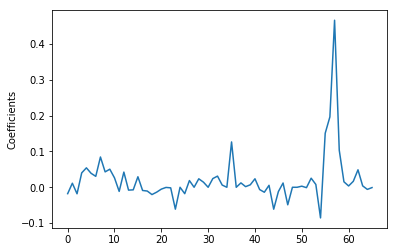

In [36]:
beta = pipe_model.stages[-1].coefficients
plt.plot(beta)
plt.ylabel('Coefficients')
plt.show()

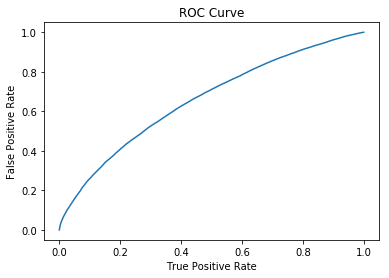

Training set areaUnderROC: 0.6574967153665597


,FPR,TPR
0,0.000000,0.000000
1,0.002297,0.018790
2,0.005424,0.036632
3,0.009795,0.053055
4,0.014485,0.069114
5,0.019941,0.084298
6,0.025174,0.099738
7,0.031523,0.113903
8,0.037553,0.128432
9,0.043679,0.142852


In [37]:
trainingSummary = pipe_model.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
roc

In [38]:
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
maxFMeasure

Row(max(F-Measure)=0.6460060432323546)

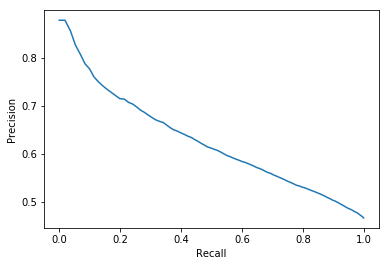

In [39]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
#pr['recall']

In [40]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [41]:
va =feature.VectorAssembler(inputCols=['A1Cresult',
 'African_American',
 'Asian',
 'Caucasian',
 'Circulatory',
 'Circulatory2',
 'Circulatory3',
 'Diabetes',
 'Diabetes2',
 'Diabetes3',
 'Digestive',
 'Digestive2',
 'Digestive3',
 'Genitourinary',
 'Genitourinary2',
 'Genitourinary3',
 'Hispanic',
 'Injury',
 'Injury2',
 'Injury3',
 'Muscuskeletal',
 'Muscuskeletal2',
 'Muscuskeletal3',
 'Neoplasms',
 'Neoplasms2',
 'Neoplasms3',
 'Respiratory',
 'Respiratory2',
 'Respiratory3',
 'acarbose',
 'acetohexamide',
 'age',
 'change',
 'chlorpropamide',
 'citoglipton',
 'diabetesMed',
 'examide',
 'female',
 'glimepiride',
 'glimepiridepioglitazone',
 'glipizide',
 'glipizidemetformin',
 'glyburide',
 'glyburidemetformin',
 'insulin',
 'male',
 'max_glu_serum',
 'metformin',
 'metforminpioglitazone',
 'metforminrosiglitazone',
 'miglitol',
 'nateglinide',
 'num_lab_procedures',
 'num_medications',
 'num_procedures',
 'number_diagnoses',
 'number_emergency',
 'number_inpatient',
 'number_outpatient',
 'pioglitazone',
 'repaglinide',
 'rosiglitazone',
 'time_in_hospital',
 'tolazamide',
 'tolbutamide',
 'troglitazone'] ,  outputCol='features')

In [42]:
sd = feature.StandardScaler(inputCol='features',outputCol = 'sdfeatures')

# Logistic model 2 with all features and reg param

In [43]:
lr = classification.LogisticRegression(labelCol='readmittedbinary', featuresCol='sdfeatures')

In [44]:
pipe_model2 = Pipeline(stages=[va,sd, lr])

In [45]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]).addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]).addGrid(lr.maxIter, [100, 200, 300]).build())

In [46]:
cv = CrossValidator(estimator=pipe_model2, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

In [47]:
cvModel = cv.fit(training_df)

In [48]:
AUC2 = evaluator.evaluate(cvModel.transform(validation_df))
AUC2

0.6526480181891485

In [49]:
param_dict = cvModel.bestModel.stages[-1].extractParamMap()

sane_dict = {}
for k, v in param_dict.items():
    #print(k)
    sane_dict[k.name] = v

best_reg = sane_dict["regParam"]
best_elastic_net = sane_dict["elasticNetParam"]
best_max_iter = sane_dict["maxIter"]
print(best_reg)
print(best_elastic_net)
print(best_max_iter)

0.1
0.0
100


In [50]:
testing_df.select("African_American", 'Asian', 'Caucasian','Hispanic','Male','Female', 'Circulatory','Circulatory2','Circulatory3').show()

+----------------+-----+---------+--------+----+------+-----------+------------+------------+
|African_American|Asian|Caucasian|Hispanic|Male|Female|Circulatory|Circulatory2|Circulatory3|
+----------------+-----+---------+--------+----+------+-----------+------------+------------+
|               0|    0|        0|       0| 0.0|   1.0|          0|           0|           0|
|               0|    0|        0|       0| 1.0|   0.0|          0|           0|           0|
|               0|    0|        0|       0| 0.0|   1.0|          0|           0|           0|
|               0|    0|        0|       0| 1.0|   0.0|          0|           0|           0|
|               0|    0|        0|       0| 0.0|   1.0|          0|           0|           0|
|               0|    0|        0|       0| 0.0|   1.0|          0|           0|           0|
|               0|    0|        0|       0| 1.0|   0.0|          0|           0|           0|
|               0|    0|        0|       0| 0.0|   1.0|     

In [51]:
validation_df.select("African_American", 'Asian', 'Caucasian','Hispanic','Male','Female', 'Circulatory','Circulatory2','Circulatory3').show()

+----------------+-----+---------+--------+----+------+-----------+------------+------------+
|African_American|Asian|Caucasian|Hispanic|Male|Female|Circulatory|Circulatory2|Circulatory3|
+----------------+-----+---------+--------+----+------+-----------+------------+------------+
|               0|    0|        0|       0| 0.0|   1.0|          0|           0|           0|
|               0|    0|        0|       0| 1.0|   0.0|          0|           0|           0|
|               0|    0|        0|       0| 0.0|   1.0|          0|           0|           0|
|               0|    0|        0|       0| 1.0|   0.0|          0|           0|           0|
|               0|    0|        0|       0| 1.0|   0.0|          0|           0|           0|
|               0|    0|        0|       0| 0.0|   1.0|          0|           0|           0|
|               0|    0|        0|       0| 1.0|   0.0|          0|           0|           0|
|               0|    0|        0|       0| 1.0|   0.0|     

In [52]:
training_df.select("African_American", 'Asian', 'Caucasian','Hispanic','Male','Female', 'Circulatory','Circulatory2','Circulatory3').show()

+----------------+-----+---------+--------+----+------+-----------+------------+------------+
|African_American|Asian|Caucasian|Hispanic|Male|Female|Circulatory|Circulatory2|Circulatory3|
+----------------+-----+---------+--------+----+------+-----------+------------+------------+
|               0|    0|        0|       0| 0.0|   1.0|          0|           0|           0|
|               0|    0|        0|       0| 1.0|   0.0|          0|           0|           0|
|               0|    0|        0|       0| 0.0|   1.0|          0|           0|           0|
|               0|    0|        0|       0| 1.0|   0.0|          0|           0|           0|
|               0|    0|        0|       0| 1.0|   0.0|          0|           0|           0|
|               0|    0|        0|       0| 1.0|   0.0|          0|           0|           0|
|               0|    0|        0|       0| 0.0|   1.0|          0|           0|           0|
|               0|    0|        0|       0| 1.0|   0.0|     

# Random forest model 1

In [53]:
modelrf = Pipeline(stages= [va, classification.RandomForestClassifier(labelCol='readmittedbinary', featuresCol="features",maxDepth=15, numTrees=30)])

In [54]:
modelrffit= modelrf.fit(training_df)

In [55]:
modelrfdf = modelrffit.transform(validation_df)

In [56]:
modelrfdf

DataFrame[A1Cresult: bigint, African_American: bigint, Asian: bigint, Caucasian: bigint, Circulatory: bigint, Circulatory2: bigint, Circulatory3: bigint, Diabetes: bigint, Diabetes2: bigint, Diabetes3: bigint, Digestive: bigint, Digestive2: bigint, Digestive3: bigint, Genitourinary: bigint, Genitourinary2: bigint, Genitourinary3: bigint, Hispanic: bigint, Injury: bigint, Injury2: bigint, Injury3: bigint, Muscuskeletal: bigint, Muscuskeletal2: bigint, Muscuskeletal3: bigint, Neoplasms: bigint, Neoplasms2: bigint, Neoplasms3: bigint, Respiratory: bigint, Respiratory2: bigint, Respiratory3: bigint, acarbose: bigint, acetohexamide: bigint, age: bigint, change: bigint, chlorpropamide: bigint, citoglipton: bigint, diabetesMed: bigint, examide: bigint, female: double, glimepiride: bigint, glimepiridepioglitazone: bigint, glipizide: bigint, glipizidemetformin: bigint, glyburide: bigint, glyburidemetformin: bigint, insulin: bigint, male: double, max_glu_serum: bigint, metformin: bigint, metform

In [57]:
AUCrf = evaluator.evaluate(modelrffit.transform(validation_df))

In [58]:
AUCrf

0.6608294808326514

In [59]:
pd.DataFrame(list(zip(featlist, modelrffit.stages[1].featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending = False).head(10)

,column,weight
57,number_inpatient,0.167490
53,num_medications,0.078835
52,num_lab_procedures,0.076473
55,number_diagnoses,0.055925
62,time_in_hospital,0.055443
31,age,0.053307
56,number_emergency,0.047625
58,number_outpatient,0.045667
54,num_procedures,0.039283
44,insulin,0.022540


In [60]:
tp = modelrfdf[(modelrfdf.readmittedbinary == 1) & (modelrfdf.prediction == 1)].count()
tn = modelrfdf[(modelrfdf.readmittedbinary == 1) & (modelrfdf.prediction == 0)].count()
fp = modelrfdf[(modelrfdf.readmittedbinary == 0) & (modelrfdf.prediction == 1)].count()
fn = modelrfdf[(modelrfdf.readmittedbinary == 0) & (modelrfdf.prediction == 0)].count()
print ("True Positives:", tp)
print ("True Negatives:", tn)
print ("False Positives:", fp)
print ("False Negatives:", fn)
#print ("Total", df.count())

r = (tp)/(tp + fn)
print ("recall", r)

p = float(tp) / (tp + fp)
print ("precision", p)

True Positives: 6596
True Negatives: 7015
False Positives: 4081
False Negatives: 11639
recall 0.3617219632574719
precision 0.6177765289875433


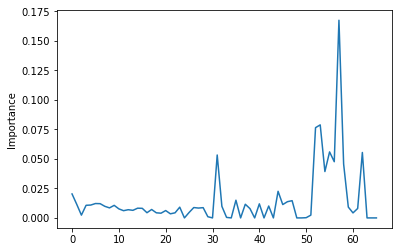

In [61]:
beta = modelrffit.stages[-1].featureImportances
plt.plot(beta)
plt.ylabel('Importance')
plt.show()

# CV RF

In [62]:
rf=classification.RandomForestClassifier(labelCol='readmittedbinary', featuresCol="features")

In [63]:
mrf = Pipeline(stages=[va,rf])

In [64]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [30]).addGrid(rf.maxDepth,[5,10,15]).build())



In [65]:
cvrf = CrossValidator(estimator=mrf, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

In [66]:
cvrf1 = cvrf.fit(training_df)

In [67]:
AUCn = evaluator.evaluate(cvrf1.transform(validation_df))
AUCn

0.6622824035827914

In [68]:
param_dict1 = cvrf1.bestModel.stages[-1].extractParamMap()

sane_dict1 = {}
for k, v in param_dict1.items():
    #print(k)
    sane_dict1[k.name] = v


best_max_depth = sane_dict1["maxDepth"]
print(best_max_depth)

10


# Multiclass for Readmitted

In [69]:
modelrfmc = Pipeline(stages= [va, classification.RandomForestClassifier(labelCol='readmitted', featuresCol="features",maxDepth=15, numTrees=30)])

In [70]:
modelrffitmc= modelrfmc.fit(training_df)

In [71]:
evaluatormc = evaluation.MulticlassClassificationEvaluator(labelCol='readmitted',predictionCol="prediction",metricName="accuracy")
AUCrfmc = evaluatormc.evaluate(modelrffitmc.transform(validation_df))

In [72]:
AUCrfmc

0.5696362210630391

In [73]:
pd.DataFrame(list(zip(featlist, modelrffitmc.stages[1].featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending = False).head(10)

,column,weight
57,number_inpatient,0.142268
53,num_medications,0.079346
52,num_lab_procedures,0.079224
62,time_in_hospital,0.056937
31,age,0.053636
55,number_diagnoses,0.053234
58,number_outpatient,0.043729
56,number_emergency,0.042484
54,num_procedures,0.039698
44,insulin,0.025757


# LR on top features of og LR

In [74]:
model_new_lr2 = Pipeline(stages=[feature.VectorAssembler(inputCols=['number_inpatient', 'number_emergency', 'number_diagnoses', 'diabetesMed', 'number_outpatient', 'Diabetes', 'Circulatory','Diabetes3','time_in_hospital','Caucasian'],
                                        outputCol='features'),sd,
                 classification.LogisticRegression(labelCol='readmittedbinary', featuresCol='sdfeatures')])


In [75]:
pipe_model3 = model_new_lr2.fit(training_df)
AUC5 = evaluator.evaluate(pipe_model3.transform(validation_df))
AUC5

0.6487506620244107

# RF on top features of og LR

In [76]:
modelrfselected = Pipeline(stages= [feature.VectorAssembler(inputCols=['number_inpatient', 'number_emergency', 'number_diagnoses', 'diabetesMed', 'number_outpatient', 'Diabetes', 'Circulatory','Diabetes3','time_in_hospital','Caucasian'],
                                        outputCol='features'), classification.RandomForestClassifier(labelCol='readmittedbinary', featuresCol="features",maxDepth=15, numTrees=30)])

In [77]:
modelrffitselected= modelrfselected.fit(training_df)

In [78]:
AUCrfselected = evaluator.evaluate(modelrffitselected.transform(validation_df))
AUCrfselected

0.6417316609657324

# LR on top RF features

In [79]:
model_new_lr3 = Pipeline(stages=[feature.VectorAssembler(inputCols=['number_inpatient','num_medications','num_lab_procedures','number_diagnoses','time_in_hospital','age','number_emergency', 'number_outpatient','num_procedures','insulin'],
                                        outputCol='features'),sd,
                 classification.LogisticRegression(labelCol='readmittedbinary', featuresCol='sdfeatures')])


In [80]:
pipe_model4 = model_new_lr3.fit(training_df)
AUC6 = evaluator.evaluate(pipe_model4.transform(validation_df))
AUC6

0.6476020531776886

# Best model

In [81]:
best_model = Pipeline(stages= [va, classification.RandomForestClassifier(labelCol='readmittedbinary', featuresCol="features",maxDepth=10, numTrees=30)])

In [82]:
bestmodel_fit= best_model.fit(training_df)

In [83]:
AUCfinal = evaluator.evaluate(bestmodel_fit.transform(testing_df))

In [84]:
AUCfinal

0.664540492637796

In [85]:
pd.DataFrame(list(zip(featlist, bestmodel_fit.stages[1].featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending = False).head(10)

,column,weight
57,number_inpatient,0.317559
56,number_emergency,0.089133
58,number_outpatient,0.075562
55,number_diagnoses,0.065023
53,num_medications,0.055932
52,num_lab_procedures,0.042118
62,time_in_hospital,0.038665
31,age,0.034248
54,num_procedures,0.031662
35,diabetesMed,0.025003


In [86]:
bestmodel_final_fit= best_model.fit(dummy_df)

# Live Demo

In [87]:
columns = ['A1Cresult',
 'African_American',
 'Asian',
 'Caucasian',
 'Circulatory',
 'Circulatory2',
 'Circulatory3',
 'Diabetes',
 'Diabetes2',
 'Diabetes3',
 'Digestive',
 'Digestive2',
 'Digestive3',
 'Genitourinary',
 'Genitourinary2',
 'Genitourinary3',
 'Hispanic',
 'Injury',
 'Injury2',
 'Injury3',
 'Muscuskeletal',
 'Muscuskeletal2',
 'Muscuskeletal3',
 'Neoplasms',
 'Neoplasms2',
 'Neoplasms3',
 'Respiratory',
 'Respiratory2',
 'Respiratory3',
 'acarbose',
 'acetohexamide',
 'age',
 'change',
 'chlorpropamide',
 'citoglipton',
 'diabetesMed',
 'examide',
 'female',
 'glimepiride',
 'glimepiridepioglitazone',
 'glipizide',
 'glipizidemetformin',
 'glyburide',
 'glyburidemetformin',
 'insulin',
 'male',
 'max_glu_serum',
 'metformin',
 'metforminpioglitazone',
 'metforminrosiglitazone',
 'miglitol',
 'nateglinide',
 'num_lab_procedures',
 'num_medications',
 'num_procedures',
 'number_diagnoses',
 'number_emergency',
 'number_inpatient',
 'number_outpatient',
 'pioglitazone',
 'repaglinide',
 'rosiglitazone',
 'time_in_hospital',
 'tolazamide',
 'tolbutamide',
 'troglitazone']
vals = [
     (5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2,-2,15,1,-2,-2,1,-2,0,-2,-2,0,-2,0,-2,1,0,0,-2,1,-2,-2,-2,59,18,5,0,0,0,2,-2,-2,-2,12,-2,-2,-2)
]

In [88]:
livedf = spark.createDataFrame(vals, columns)

In [89]:
bestmodel_final_fit.transform(livedf).select("prediction").show()

+----------+
|prediction|
+----------+
|       0.0|
+----------+

